Import necessary modules

In [6]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

Create data for learing

Default devise: cuda


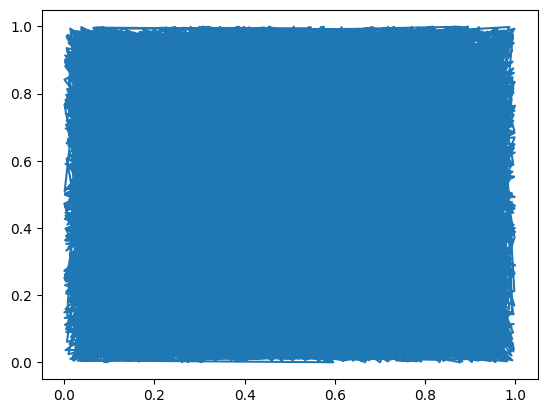

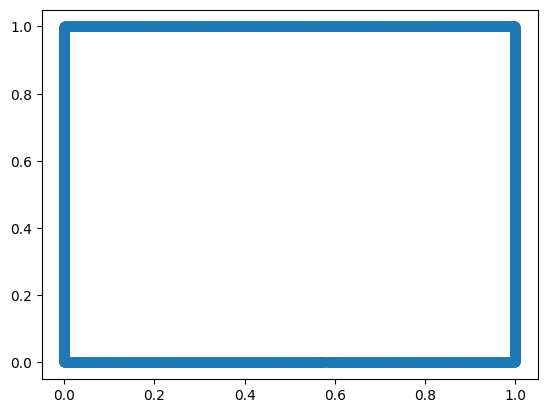

In [7]:
if torch.cuda.is_available():
    device = torch.device ("cuda")
else:
    device = torch.device ("cpu")

alpha = 0.01
epochs = 2

print (f"Default devise: {device}")

T_right = 273 / 323
T_left = 273 / 323
T_bottom = 273 / 323
T_top = 323 / 323

def create_data ():

    x_colloc = torch.rand(10000, 1, requires_grad=True).to(device)
    y_colloc = torch.rand(10000, 1, requires_grad=True).to(device)

    left_wall_x = torch.zeros ((2500, 1))
    left_wall_y = torch.rand ((2500,1))
    temp_left = torch.full ((2500, 1), T_left)

    right_wall_x = torch.ones ((2500, 1))
    right_wall_y = torch.rand ((2500,1))
    temp_right = torch.full ((2500, 1), T_right)

    top_wall_x = torch.rand ((2500, 1))
    top_wall_y = torch.ones ((2500,1))
    temp_top = torch.full ((2500, 1), T_top)

    bottom_wall_x = torch.rand ((2500, 1))
    bottom_wall_y = torch.zeros ((2500,1))
    temp_bottom = torch.full ((2500, 1), T_bottom)


    bd_x = torch.concatenate ([left_wall_x, right_wall_x, top_wall_x, bottom_wall_x]).to(device).requires_grad_(True)
    bd_y = torch.concatenate ([left_wall_y, right_wall_y, top_wall_y, bottom_wall_y]).to(device).requires_grad_(True)
    bd_temp = torch.concatenate ([temp_left, temp_right, temp_top, temp_bottom]).to(device).requires_grad_(True)



    return x_colloc, y_colloc, bd_x, bd_y, bd_temp

x_colloc, y_colloc, bd_x, bd_y, bd_temp = create_data ()

plt.plot (x_colloc.cpu().detach().numpy(), y_colloc.cpu().detach().numpy())
plt.show ()
plt.scatter (bd_x.cpu().detach().numpy(), bd_y.cpu().detach().numpy())
plt.show ()

Initializate model

In [8]:
def init_weight(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [9]:
class PINN (nn.Module):
    def __init__ (self, n_hidden, n_neurons, activation, verbose = True):
        super().__init__ ()
        self.model = nn.Sequential ()
        self.build_NN (n_hidden, n_neurons, activation)
        self.model.to(device)


        if verbose:
            print (self.model)

        self.model.apply (init_weight)


    def build_NN (self,n_hidden, n_neurons, activation):
        self.model.add_module ('input layer',nn.Linear (2, n_neurons))
        self.model.add_module ('activation func', activation)
        
        for _ in range (n_hidden-1):
            self.model.add_module (f'hidden layer number: {_}', nn.Linear (n_neurons, n_neurons))
            self.model.add_module (f'activation func {_}', activation)

        self.model.add_module ('Output layer',nn.Linear (n_neurons, 1))

    def forward (self, x, y):
        x = torch.concat ([x,y], dim=1).to(device)
        out = self.model (x)
        return out
    

def pde_loss(model, x, y):
    u = model(x, y)

    u_x = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(x_colloc))[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(x_colloc))[0]

    u_y = torch.autograd.grad(u, y, create_graph=True, grad_outputs=torch.ones_like(y_colloc))[0]
    u_yy = torch.autograd.grad(u_y, y, create_graph=True, grad_outputs=torch.ones_like(y_colloc))[0]
    
    physics_loss = u_xx + u_yy
    physics_loss = torch.mean(physics_loss**2)
    return physics_loss

def boundary_loss(model, x, y):

    u = model(x, y)
    loss = torch.mean(torch.square(bd_temp - u))
    return loss



Training model

In [10]:
model = PINN(5, 25, nn.Tanh())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
total_loss_graph = []

for epoch in range(epochs):
    optimizer.zero_grad()
    eq_loss = pde_loss(model, x_colloc, y_colloc)
    bc_loss = boundary_loss(model, bd_x, bd_y)


    total_loss = eq_loss + bc_loss
    total_loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(f"epoch: {epoch}, loss: {total_loss.item()}")
        total_loss_graph.append (total_loss.item())

Sequential(
  (input layer): Linear(in_features=2, out_features=25, bias=True)
  (activation func): Tanh()
  (hidden layer number: 0): Linear(in_features=25, out_features=25, bias=True)
  (activation func 0): Tanh()
  (hidden layer number: 1): Linear(in_features=25, out_features=25, bias=True)
  (activation func 1): Tanh()
  (hidden layer number: 2): Linear(in_features=25, out_features=25, bias=True)
  (activation func 2): Tanh()
  (hidden layer number: 3): Linear(in_features=25, out_features=25, bias=True)
  (activation func 3): Tanh()
  (Output layer): Linear(in_features=25, out_features=1, bias=True)
)
epoch: 0, loss: 0.5585471987724304


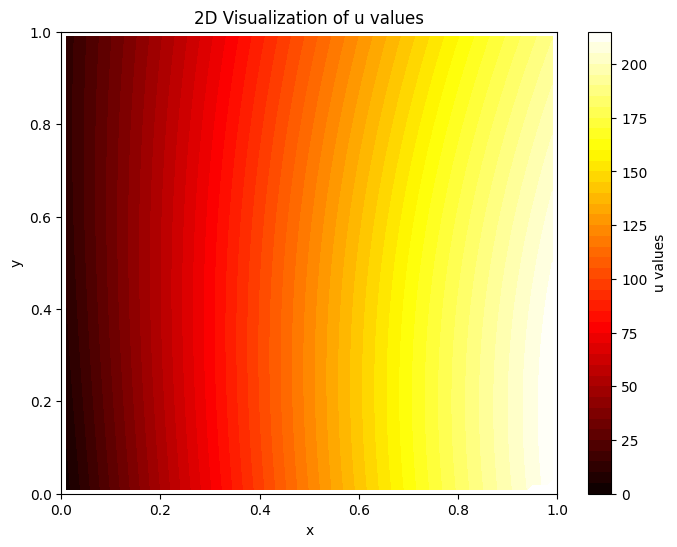

In [11]:
from scipy.interpolate import griddata

x = torch.rand(10000, 1)
y = torch.rand(10000, 1)

u_value = model(x, y).cpu().detach().numpy()  
u_value = u_value * 323 

x = x.numpy().flatten()
y = y.numpy().flatten()


grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]


grid_u = griddata((x, y), u_value.flatten(), (grid_x, grid_y), method='cubic')


plt.figure(figsize=(8, 6))
plt.contourf(grid_x, grid_y, grid_u, levels=50, cmap='hot')  
plt.colorbar(label='u values')  
plt.title('2D Visualization of u values')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

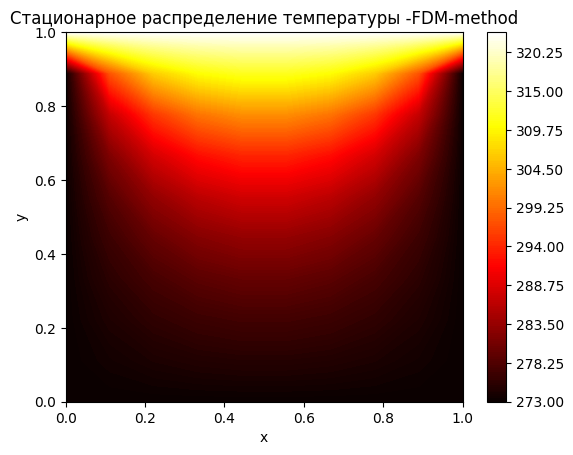

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
Lx = 1.0  # Length of the domain in the x-direction
Ly = 1.0  # Length of the domain in the y-direction
Nx = 10   # Number of grid points in the x-direction
Ny = 10   # Number of grid points in the y-direction
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Create the grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
T = np.zeros((Nx, Ny))

# Boundary conditions
T[:, 0] = 273/323 # Left boundary
T[:, -1] = 273/323   # Right boundary
T[0, :] = 273/323   # Bottom boundary
T[-1, :] = 323/323 # Top boundary

# Finite difference method
for _ in range(30000):
    T_new = T.copy()
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            T_new[i, j] = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1])
    if np.allclose(T, T_new, rtol=1e-6):
        break
    T = T_new

# Plot the result
plt.contourf(x, y, T*323, 200, cmap='hot')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Стационарное распределение температуры -FDM-method')
plt.show()

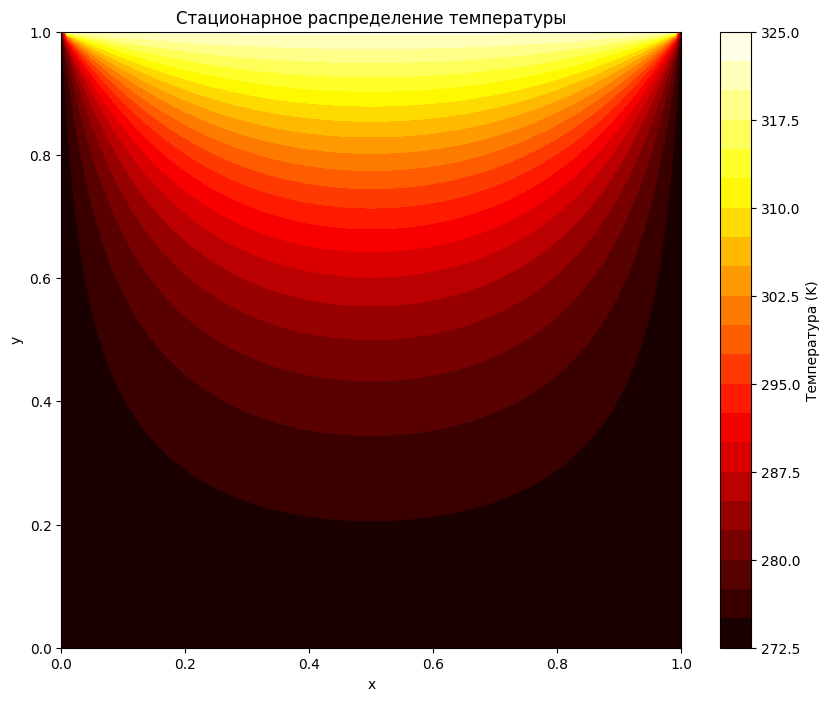

In [13]:
import numpy as np
import matplotlib.pyplot as plt


nx = 100  # количество узлов по x
ny = 100  # количество узлов по y
Lx = 1.0  # длина области по x
Ly = 1.0  # длина области по y
dx = Lx / (nx - 1)  # шаг по x
dy = Ly / (ny - 1)  # шаг по y

# Граничные условия
T_left = 273
T_right = 273
T_bottom = 273
T_top = 323

# Инициализация температурного поля
T = np.zeros((ny, nx))

# Установка граничных условий
T[0, :] = T_bottom     # верхняя граница
T[-1, :] = T_top  # нижняя граница
T[:, 0] = T_left     # левая граница
T[:, -1] = T_right   # правая граница

# Параметры итерационного процесса
max_iter = 10000
tol = 1e-5  # критерий сходимости

# Решение уравнения Лапласа методом конечных разностей
for iteration in range(max_iter):
    T_old = T.copy()
    
    # Обновление внутренних точек
    for i in range(1, ny-1):
        for j in range(1, nx-1):
            T[i, j] = 0.25 * (T_old[i+1, j] + T_old[i-1, j] + 
                              T_old[i, j+1] + T_old[i, j-1])
    
    # Проверка сходимости
    if np.max(np.abs(T - T_old)) < tol:
        print(f"Решение сошлось на итерации {iteration}")
        break

# Визуализация результатов
plt.figure(figsize=(10, 8))
plt.contourf(np.linspace(0, Lx, nx), np.linspace(0, Ly, ny), T, levels=20, cmap='hot')
plt.colorbar(label='Температура (K)')
plt.title('Стационарное распределение температуры')
plt.xlabel('x')
plt.ylabel('y')
plt.show()